# Final Data Analysis Report: Data Visualization and Predictive Modeling for Bank Term Deposit Subscription
#### Submission for MAC x OCRUG Data Science Hackathon Event

#### Team Math Geeks + Ryan

Team Members: Ryan Luu, Kent Jitpatima, Sunny Zhou, Vu Tran, and Alex Oineza

# Table of Contents

1. Business Problem
2. Data Collection and Cleaning
3. Data Analysis
4. Conclusion

# Abstract

This notebook summarizes our data visualization, predictive modeling, and analysis of our submission to the OCRUG Data Science Hackathon competition helf at the UCI Paul Merage School of Bussiness. The purpose of this report is to document our team's assumptions, thought process, and data modeling throughout the weekend.

# Background

The original dataset, consisting of 45,211 observations and order by date from May 2008 to November 2010, was collected by a Portugese Marketing Campaign. The observations includes the client's age, balance, occupation, along with other features, and whether they subscribed to a bank term deposit. A term deposit is a fixed-term investment that includes the deposit of a money into an account at a financial institution. Term deposit investments usually carry short-term maturities randing from one month to a few years and will have varying levels of required minimum deposits.<sup>1</sup>

More information regarding the dataset can be found at the 
<a href="http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#">UCI Machine Learning Repository</a>.

# Set-Up

In [1]:
#Read provided data set
data <- read.csv("bank-full.csv", TRUE, ';')

In [5]:
install.packages("gridExtra")
install.packages("DMwR")
#Packages
library(randomForest)
library(caret)
library(ggplot2)
library(lubridate)
library(scales)
library(gridExtra)
#library(DMwR)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
also installing the dependencies ‘bitops’, ‘gtools’, ‘gdata’, ‘caTools’, ‘gplots’, ‘ROCR’

Warning message in install.packages("DMwR"):
“installation of package ‘bitops’ had non-zero exit status”Warning message in install.packages("DMwR"):
“installation of package ‘gtools’ had non-zero exit status”Warning message in install.packages("DMwR"):
“installation of package ‘gdata’ had non-zero exit status”Warning message in install.packages("DMwR"):
“installation of package ‘caTools’ had non-zero exit status”Warning message in install.packages("DMwR"):
“installation of package ‘gplots’ had non-zero exit status”Warning message in install.packages("DMwR"):
“installation of package ‘ROCR’ had non-zero exit status”Warning message in install.packages("DMwR"):
“installation of package ‘DMwR’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


# Overview of the Data

Before performing our data analysis, we would like to observe the data's structure.

In [6]:
head(data)

age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no


In [7]:
str(data)

'data.frame':	45211 obs. of  17 variables:
 $ age      : int  58 44 33 47 33 35 28 42 58 43 ...
 $ job      : Factor w/ 12 levels "admin.","blue-collar",..: 5 10 3 2 12 5 5 3 6 10 ...
 $ marital  : Factor w/ 3 levels "divorced","married",..: 2 3 2 2 3 2 3 1 2 3 ...
 $ education: Factor w/ 4 levels "primary","secondary",..: 3 2 2 4 4 3 3 3 1 2 ...
 $ default  : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 2 1 1 ...
 $ balance  : int  2143 29 2 1506 1 231 447 2 121 593 ...
 $ housing  : Factor w/ 2 levels "no","yes": 2 2 2 2 1 2 2 2 2 2 ...
 $ loan     : Factor w/ 2 levels "no","yes": 1 1 2 1 1 1 2 1 1 1 ...
 $ contact  : Factor w/ 3 levels "cellular","telephone",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ day      : int  5 5 5 5 5 5 5 5 5 5 ...
 $ month    : Factor w/ 12 levels "apr","aug","dec",..: 9 9 9 9 9 9 9 9 9 9 ...
 $ duration : int  261 151 76 92 198 139 217 380 50 55 ...
 $ campaign : int  1 1 1 1 1 1 1 1 1 1 ...
 $ pdays    : int  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 ...
 $ previous : int  0 0 0

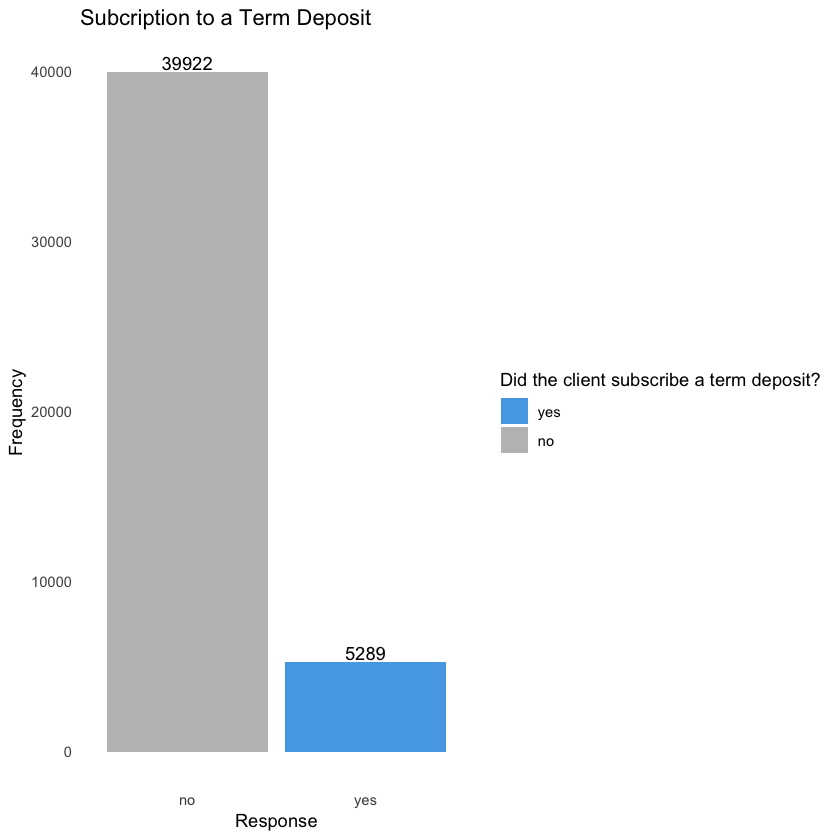

In [8]:
#Color Code
colory <- "#56a8e8"
colorn <- "grey75"

ggplot(data, aes(y, fill = y)) + geom_bar() +
  theme_minimal()+
  scale_fill_manual(values = c(colorn,colory)) +
  guides(fill = guide_legend(reverse = TRUE)) +
  geom_text(stat = 'count',aes(label =..count.., vjust = -0.2)) +
  theme(panel.background=element_blank(),panel.border=element_blank(),panel.grid.major=element_blank(),
          panel.grid.minor=element_blank(),plot.background=element_blank()) +
  labs(title = "Subcription to a Term Deposit",
       x = "Response",
       y = "Frequency",
       fill = "Did the client subscribe a term deposit?")

# Business Problem

Based on this graph, we immediately knew there is an imbalance of those who agree whether or not to subscribe to a term deposit. Our assumptions is that the bank is calling clients at random and hoping they subscribe to a term deposit. If we were to develop a predictive model, we need to ensure that there is enough observations who responded "yes" in both the train and test dataframe. 

Business Problem: Employees contact many clients but only a rough percentage of them subsribe to a bank term deposit. Our goal is to determine which demographic of customers the bank should be focusing on to maximize subscriptions. For example, are younger people more likely to subscribe to a bank term? What professions are more likely to subscribe? By knowing which audience is their target audience, the bank can properly allocate its resources and call those who are likely to subscribe. 

In our first attempt to analyze the data we will create a predictive model in predicting whether a client will subscribe to a bank term deposit. We will identify which features are the most important in the model. Determine which feature is important in the predictive model can help determine the banks target audience.

# Data Partitioning

In [9]:
#Create two new dataframe, data_yes has all of the obs with y=yes, data_no has all of the obs with y=no
data_yes <- data[ which(data$y=='yes'),]
data_no <- data[ which(data$y=='no'),]

set.seed(1234)
ind <- sample(2,nrow(data_no), replace = TRUE, prob = c(0.7,0.3))
train <- data_no[ind==1,]
test <- data_no[ind==2,]

ind <- sample(2,nrow(data_yes), replace = TRUE, prob = c(0.7,0.3))
train1 <- data_yes[ind==1,]
test1 <- data_yes[ind==2,]

train <- rbind(train, train1)
test <- rbind(test, test1)

In [10]:
rf <- randomForest(y~., data=train)

In [11]:
print(rf)


Call:
 randomForest(formula = y ~ ., data = train) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 9.19%
Confusion matrix:
       no  yes class.error
no  26996  986  0.03523694
yes  1922 1739  0.52499317


In [12]:
library(caret)
p1 <- predict(rf, train)
confusionMatrix(p1, train$y)

#Prediction & Confusion MAtrix - test data
p2 <- predict(rf, test)
confusionMatrix(p2, test$y)

ERROR: Error: package e1071 is required


Although this model sports more than 90% accuracy, accuracy of the model is sometimes not the best indicator in measuring the performance. The model performs extremely well in predicting whether a client will reject a bank term deposit. However, it is wrong more than half the time when trying to predict whether a client actually does subsribe to a bank term. Specifically, despite its desireable true negative rate, the model sports a poor false positive rate<br>

Because of such imbalance of yes and no, the model can easily keep predicting no for the most part and still be fairly accurate.We will need to figure out an approach to offset the imbalance. We will create variable importsance plot to measure the weight each of these variables has on our model.

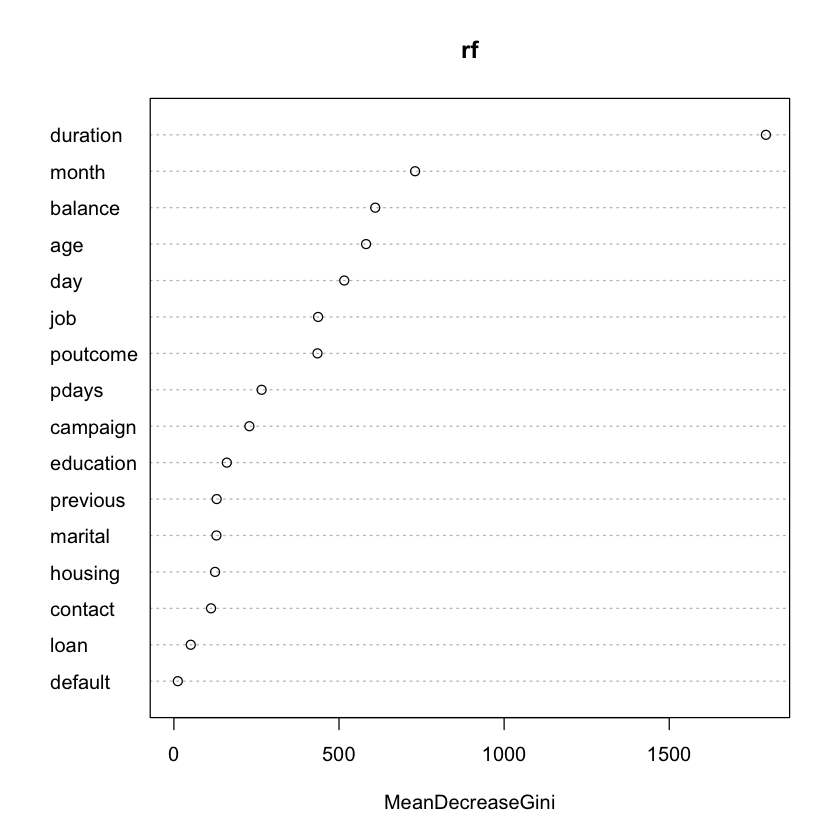

In [14]:
varImpPlot(rf)

Questions to ask: <br>
Why is duration the most influential variable in predicting who will subscribe to a bank term deposit? <br>
Why is the day of the month even a factor?
Overall, variables such as balance and age makes sense in predicting. Here is our hypothesis on why those variables are significant: <br>

If you have a large balance, you are likely able to afford a term deposit. Unfortunately income would be a useful metric also, but we dont have data on that. Nonetheless we didnt have time during the hackathon to go into it.<br>

As for age, here are the assumptions: When you are young, you probably got your first job and want to invest early. However, by the time you are around 30, you are less likely to invest because you have more financial constraints (having children). And Retired people are more likely to invest because they don't spend much perhaps and want to work on their retirement funds. <br><Br> But why duration and day?

Questions to ask: <br>
Why is duration the most influential variable in predicting who will subscribe to a bank term deposit? <br>
Month makes sense as a factor but why is the day of the month considered?  We will need to further investigate.

# Investigating Duration

Duration of the call with the client is measured in seconds. The model is suggesting, the longer the call with the client, the more likely they are to subscribe to a term deposit. However, duration of the call is not something we can predict before making the call. We feel you are more likely to have a longer call if youve already agreed to saying yes, thus duration may actually be a response variable to whether a customer subscribes rather than the other way around. 

In [15]:
summary(data_yes$duration)
summary(data_no$duration)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    8.0   244.0   426.0   537.3   725.0  3881.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0    95.0   164.0   221.2   279.0  4918.0 

Here we can see that on average those who agree to a bank term deposit on average already have longer call durations.

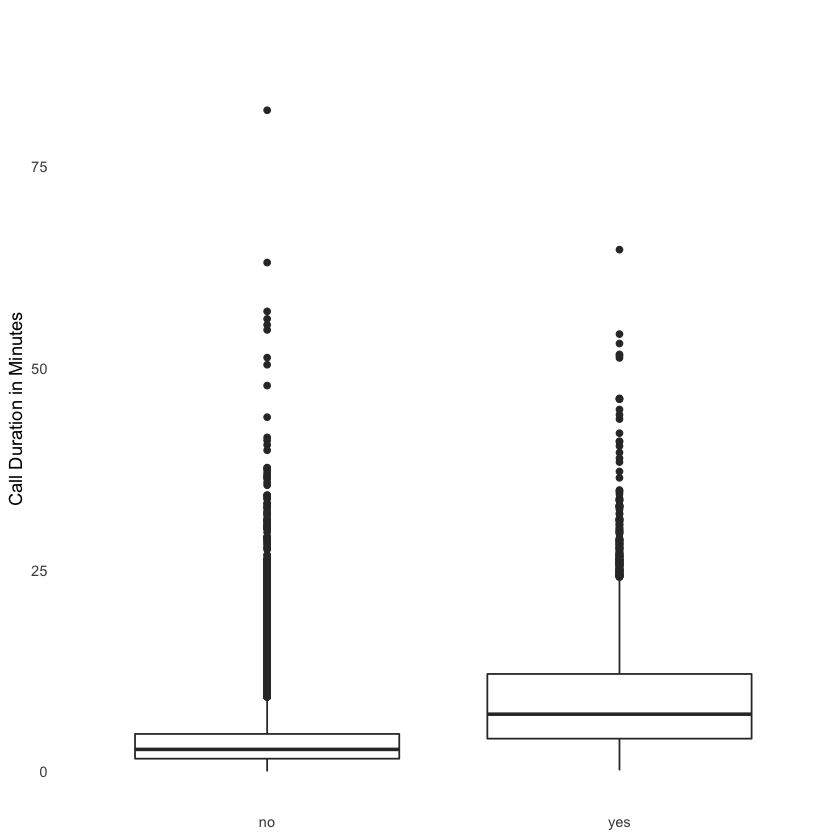

In [16]:
ggplot(data, aes(y, duration/60)) + 
geom_boxplot() + 
theme_minimal() +
theme(axis.line=element_blank(),legend.position="bottom",
          panel.background=element_blank(),panel.border=element_blank(),panel.grid.major=element_blank(),
          panel.grid.minor=element_blank(),plot.background=element_blank()) +
ylim(0, 90) +
xlab(NULL) + 
ylab("Call Duration in Minutes") +
labs(fill = "Subscribe Bank Term Depsoit")

From this plot we can see there was an higher average duration of call within those who agreed to a bank term deposit versus those who did not further implying our earlier prediction. Since variable importance plot has duration as the biggest influnce of our model, using it as a classification will create a unjustified bias.

After some discussion, we feel that we should remove the variable duration because it does not make sense on how it can predict whether a client will subscribe to a term deposit. Maybe the longer you talk to the client, they will eventually "give-in" and subscribe to a term deposit? Most likely not - the clients would probably just hang up on the caller. Perhaps why the calls are so long for people who subsribed yes is because they were already planning to subsribe and were asking questions regarding the term deposit. Nonetheless, the length of the phone call duration should not be a feature to consider.

# Investigating Day and Month

#### Let's observe the number of observation for each month

In [17]:
#Convert Month into month number
data$month_num[data$month == 'jan'] = 1 
data$month_num[data$month == 'feb'] = 2 
data$month_num[data$month == 'mar'] = 3 
data$month_num[data$month == 'apr'] = 4 
data$month_num[data$month == 'may'] = 5 
data$month_num[data$month == 'jun'] = 6 
data$month_num[data$month == 'jul'] = 7 
data$month_num[data$month == 'aug'] = 8 
data$month_num[data$month == 'sep'] = 9 
data$month_num[data$month == 'oct'] = 10 
data$month_num[data$month == 'nov'] = 11
data$month_num[data$month == 'dec'] = 12 

#Create a date column by combining month number and day. 2008 is a dummy year since observations did not include the year of the obs.
data$date <- paste(data$month_num,data$day, "2008")
data$date <- mdy(data$date)

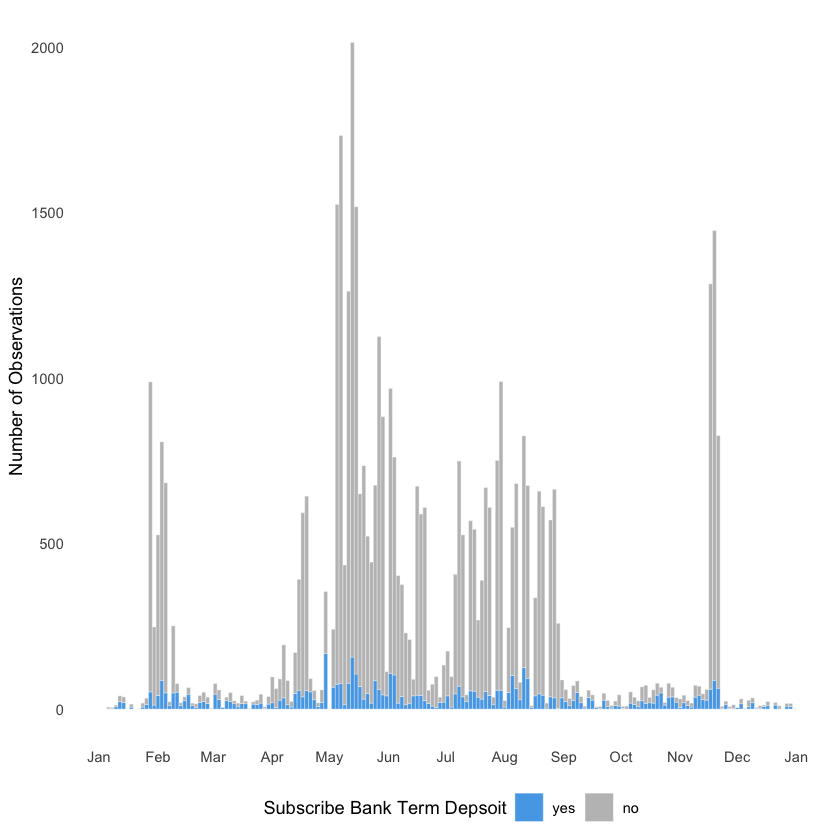

In [18]:
ggplot(data, aes(date, fill = y)) + 
  geom_histogram(binwidth = 2,colour = "white", size = 0.1) + 
  theme_minimal() +
  scale_fill_manual(values = c(colorn,colory)) +
  guides(fill = guide_legend(reverse = TRUE)) +
  scale_x_date(date_labels="%b",date_breaks  ="1 month") + 
  theme(axis.line=element_blank(), legend.position="bottom",
          panel.background=element_blank(),panel.border=element_blank(),panel.grid.major=element_blank(),
          panel.grid.minor=element_blank(),plot.background=element_blank()) +
  xlab(NULL) + 
  ylab("Number of Observations") + 
  labs(fill = "Subscribe Bank Term Depsoit")


Based on this graph, it appears that there are spikes in number of observations recorded. We are not sure why but my team has decided to make the assumption that perhaps the calls in the marketing campaigns were scheduled that way. For example, the callers were tasked to operate on specific months and days when carrying out the campaign. However, because of this, it skews the results. As a result, we feel that we should remove the variables month and days if we want to build a model in predicting term deposits. 

# Investigating Age

Here we predict that age will have huge impact on your probability of agreesing to a term deposit. Our reasoning behind this is that depening on your age you will be in a different stage in life. When you are young you may have a low amount of disposable income and lack of knowledge of financial investments, thus you may be less likely to subscribe to a bank deposit. When you are middle age and starting a family you may also be less liekly to subscribe to a bank deposit term due to family reasons. In contrast when you are above 60 you are reaching an age where thinking about retirement becomes the norm, thus you may be more likely to agree to a term desposit above this age.


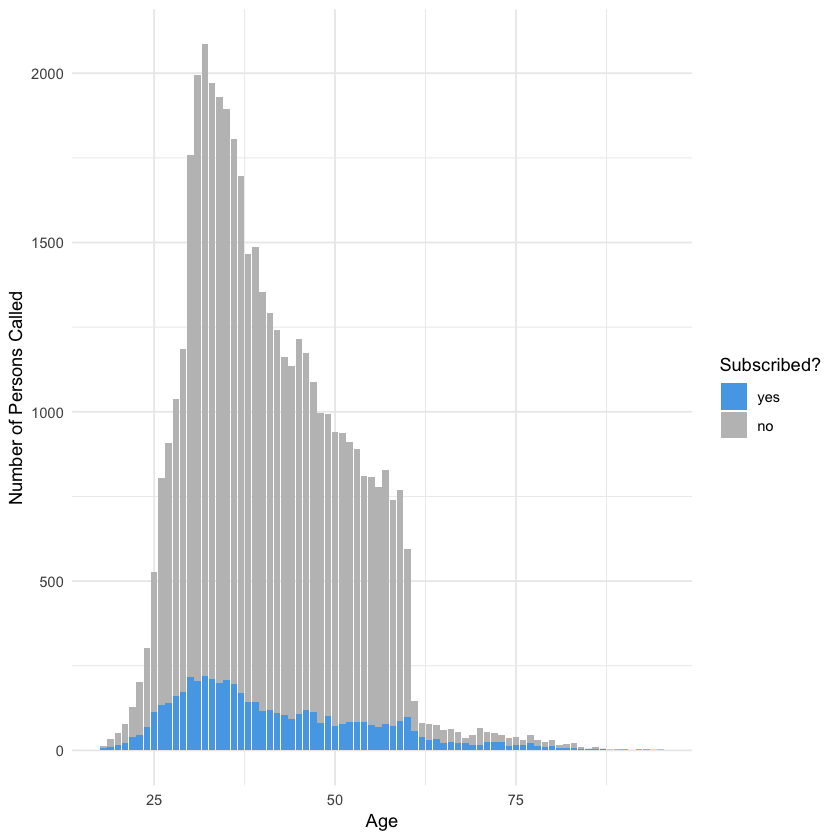

In [22]:

colory <- "#56a8e8"
colorn <- "grey75"  

library(ggplot2)
ggplot(data, aes(age, fill = y)) + geom_bar() +
  theme_minimal() + scale_fill_manual(values = c(colorn,colory)) +
  labs(title = NULL, 
  x = "Age",
  y = "Number of Persons Called",
  fill = "Subscribed?") +
  guides(fill = guide_legend(reverse = TRUE))

After producing a plot for age versus observed responses, we notice that not only was the data relatively normal, there was a huge drop in attempts made to contact a client and also an increase in the ratio between yes responses and no responses.

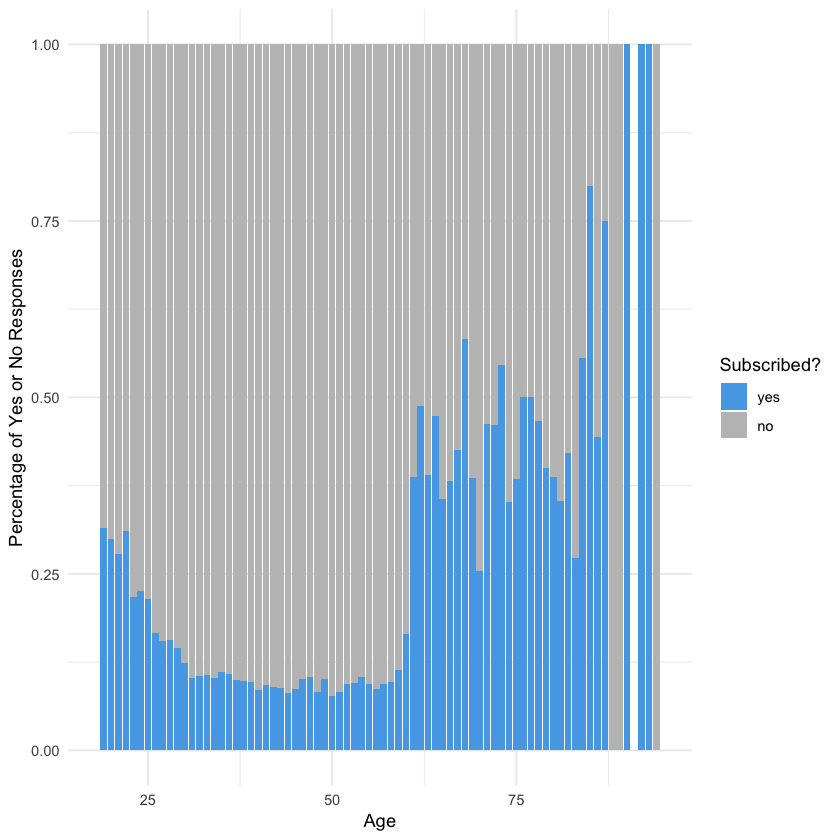

In [25]:
suppressWarnings(print(ggplot(data, aes(age, fill = y)) + geom_bar(position = "fill") +
  theme_minimal() + scale_fill_manual(values = c(colorn,colory)) +
  labs(title = NULL, 
  x = "Age",
  y = "Percentage of Yes or No Responses",
  fill = "Subscribed?") +
  xlim(18,95) +
  guides(fill = guide_legend(reverse = TRUE))))

As we can see the percentages of yes responses greatly inceased after age 60. In addition to this the younger group of those who were age 30 or less is higher than those who were middle age. Below we produced plots observing frequency between three groups.<br><Br>
Group 1: Ages 18 - 29<br>
Group 2: Ages 30 - 59<br>
Group 3: Ages 60+<br>

In [26]:
data_age1 <- data[which(data$age>=18 & data$age <30),]
data_age2 <- data[which(data$age>=30 & data$age <60),]
data_age3 <- data[which(data$age>60),]

In [27]:
p1 <- ggplot(data_age1, aes(y, fill = y)) + 
  geom_bar(show.legend = FALSE) +
  theme_minimal()+
  scale_fill_manual(values = c(colorn,colory)) +
  guides(fill = guide_legend(reverse = TRUE)) +
  theme(axis.line=element_blank(),  
          axis.title.y=element_blank(),
          panel.background=element_blank(),panel.border=element_blank(),panel.grid.major=element_blank(),
          panel.grid.minor=element_blank(),plot.background=element_blank()) +
  labs(title = "Age Group 18-29",
       x = NULL,
       y = "Frequency",
       fill = "Did the client subscribe a term deposit?")

p2 <- ggplot(data_age2, aes(y, fill = y)) + 
  geom_bar(show.legend = FALSE) +
  theme_minimal()+
  scale_fill_manual(values = c(colorn,colory)) +
  guides(fill = guide_legend(reverse = TRUE)) +
  theme(axis.line=element_blank(),
          axis.title.y=element_blank(),
          panel.background=element_blank(),panel.border=element_blank(),panel.grid.major=element_blank(),
          panel.grid.minor=element_blank(),plot.background=element_blank()) +
  labs(title = "Age Group 30-59",
       x = NULL,
       y = NULL,
       fill = "Did the client subscribe a term deposit?")

p3 <- ggplot(data_age3, aes(y, fill = y)) + 
  geom_bar(show.legend = FALSE) +
  theme_minimal()+
  scale_fill_manual(values = c(colorn,colory)) +
  guides(fill = guide_legend(reverse = TRUE)) +
  theme(axis.line=element_blank(),
          panel.background=element_blank(),panel.border=element_blank(),panel.grid.major=element_blank(),
          panel.grid.minor=element_blank(),plot.background=element_blank()) +
  labs(title = "Age Group 60+",
       x = NULL,
       y = NULL,
       fill = "Did the client subscribe a term deposit?")

# Frequency of Term Deposit Subscription by Age Group

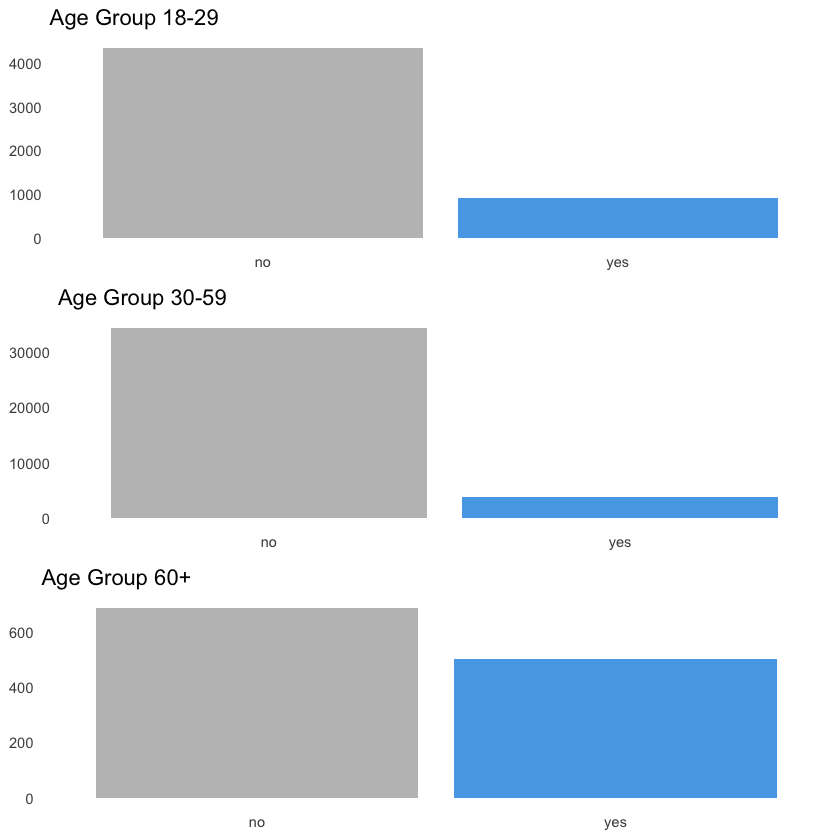

In [28]:
grid.arrange(p1, p2, p3, nrow = 3)

# Reattempt at randomForest with synthetic data

Removing duration, month, and day from the date column since we believe it serves no purpose in the predictive model. Earlier, we tried to solve the imbalance of yes and no by trying to distribute the 'yes' into both the train and test. Our new attempt is to create synthetic data to offset the imbalance.

In [ ]:
data_c <- subset(data, select =-c(duration, month, day, date, month_num))
table(data_c$y)

In [ ]:
newData_c <- SMOTE(y ~ ., data_c, perc.over = 600,perc.under=100)
table(newData_c$y)

In [ ]:
set.seed(1234)
ind <- sample(2,nrow(newData_c), replace = TRUE, prob = c(0.7,0.3))
train <- newData_c[ind==1,]
test <- newData_c[ind==2,]

In [ ]:
rf <- randomForest(y~., data=train)
print(rf)

In [ ]:
p1 <- predict(rf, train)
confusionMatrix(p1, train$y)

In [ ]:
p2 <- predict(rf, test)
confusionMatrix(p2, test$y)

Our new model definitely improved with the new synthetic data. There were enough observations with those who subsribed to properly train the model in predicting a subscription. Our first randomForest model was roughly 91% accuracy. Our second randomForest model has an 87% accuracy. However, despite its lower accuracy, it has a class error of roughly 20% in predicting yes, which is way better than our previous model with over 50% class error.

In [ ]:
varImpPlot(rf)

In [ ]:
lm(y~., data = train)

# Limitations of our Analysis

Because the dataset was collected during the Great Recession, a financial crisis that severely affected nations worldwide, our predictive model may not be relevant. Many people struggled financially, which may have affected their ability in affording a term deposit. Furthermore, many individuals may have lost faith in the financial institutions. Nonetheless, there are many variables in play when reflecting upon Portugal's economy from 2008 - 2010. Specifically,the predictive model we built in determining whether a client will subscribe to a bank term deposit may not be accurate in 2019 because Portugal's 2019 economy heavily differs than that of its 2008-2010 economy. 

Although synthesizing data for our classification model leads to no information loss, we increased the risk of overfitting the model since it replicates the minority class events - thus the model's accuracy may decrease when introduced to new variables or a new environment. Then again, the data was collected during the Great Repression, so this model is not very accurate to begin with. 

# Conclusion

Lorem ipsum dolor sit amet, est nibh atqui commune cu, simul tritani propriae ex mel. Tamquam alienum reprehendunt an sed. Vix deleniti perfecto ne, mei prodesset reprimique eu, ius ei commodo molestiae. Ne phaedrum accusata disputationi sea, id qui malorum efficiantur. Quo ad possim oblique graecis, his ex iriure eligendi corrumpit.

His diam forensibus contentiones et, vix sumo expetenda et. Ut magna dicant consectetuer vel, dicta platonem temporibus eos id. Choro civibus insolens et vis, qui eu legendos patrioque, latine eloquentiam liberavisse eam at. Quod meis ullum et mel. Facilisi instructior eam ad.

Accusamus consequat eam cu, pri id docendi ancillae perfecto. No pro quando disputationi. Sea et eros putent utamur, an iriure prompta comprehensam nec. At qui latine nominati complectitur, cu vim iudico graeco accusam.

Usu ex vidit voluptatum. Sed aliquip quaeque mentitum et. Populo quaeque assueverit per no, pro erroribus conceptam reformidans id. Et meis homero per. Vide quaestio in vel, vix amet sumo dolorem ex, eam te sonet inermis.

Mei an vulputate reformidans, an doctus corpora sed. Iriure omittantur vis ut, dicit errem veritus ne eam. Et nec justo scaevola necessitatibus, mazim persecuti ex mel, ut iriure debitis sea. In his quis detracto consulatu. Appareat consectetuer sea ad, ea est dolor albucius. Duo sonet accusamus appellantur no, quo an purto erat placerat, eu congue labitur corrumpit est.

# Reference

1. Chen, J. (2019, August 22). Term Deposit Definition. Retrieved November 13, 2019, from https://www.investopedia.com/terms/t/termdeposit.asp.